# Probe similarities by tree depth

Train per-depth distance probes on cached activations from the traversal pipeline, then compare the learned subspaces.

Note: PCA-preprocessed probes store both PCA-space projections and full-space projections; subspace comparisons prefer the full-space projection when available.


In [38]:
from __future__ import annotations

from pathlib import Path
import sys
from typing import Any, Dict, List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

NOTEBOOK_DIR = Path.cwd().resolve()
for candidate in [NOTEBOOK_DIR, *NOTEBOOK_DIR.parents]:
    if (candidate / 'cutter').exists():
        PROJECT_ROOT = candidate
        break
else:
    raise RuntimeError('Could not locate repository root containing cutter/')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from cutter.utils.tree.encoding import DEVICE, set_global_seed
from cutter.utils.tree.trees import DistanceProbeConfig, pairwise_tree_distances
from cutter.utils.tree.probing import evaluate_probes
from cutter.utils.shared.paths import embeddings_path as default_embeddings_path, probe_path, dataset_tag
from cutter.utils.shared.basic import parse_range_arg, split_balanced
from cutter.scripts.evaluate_probe import (
    load_embedding_cache,
    load_responses,
    build_layer_from_cache,
    )

In [39]:
# Experiment configuration derived from pipeline defaults
SEED = 42
TRAIN_SPLIT = 1.0
DEPTH_RANGE = [1, 2]
STEPS_RANGE = [1, 2]
NUM_SAMPLES = 1000
MIN_DEPTH, MAX_DEPTH = parse_range_arg(DEPTH_RANGE, "depth-range", min_value=1)
MIN_STEPS, MAX_STEPS = parse_range_arg(STEPS_RANGE, "steps-range", min_value=1)
STEPS_TAG = (MIN_STEPS, MAX_STEPS) if MIN_STEPS != MAX_STEPS else MIN_STEPS
DATASET_TAG = dataset_tag(MIN_DEPTH, MAX_DEPTH, NUM_SAMPLES, STEPS_TAG)
MODEL_TAG = 'DeepSeek-R1-Distill-Qwen-14B'
MODEL_ID = f'deepseek-ai/{MODEL_TAG}'
NORMALIZE_TREE = False

DATASET_DIR = PROJECT_ROOT / 'cutter/data' / DATASET_TAG / 'models' / MODEL_TAG
RESPONSES_PATH = DATASET_DIR / 'responses.jsonl'
EMBEDDINGS_PATH = DATASET_DIR / 'embeddings.npz'

# Probe artifacts (defaults match evaluate_probe.py)
PROJ_DIM = 5
PCA_COMPONENTS = 10
probe_path_primary = probe_path(DATASET_TAG, MODEL_ID, PROJ_DIM, NORMALIZE_TREE, PCA_COMPONENTS)
probe_path_legacy = DATASET_DIR / 'probes' / ('probe_normtree_proj16.npz' if NORMALIZE_TREE else 'probe_proj16.npz')
PIPELINE_RESULTS = probe_path_primary if probe_path_primary.exists() else probe_path_legacy
if PIPELINE_RESULTS.exists():
    with np.load(PIPELINE_RESULTS, allow_pickle=True) as payload:
        pipeline_meta = payload['meta'].item()
else:
    pipeline_meta = {}

LAYER_INDICES = [31]  # list(pipeline_meta.get('layers', [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]))
PROJ_DIM = int(pipeline_meta.get('proj_dim', PROJ_DIM))
LR = float(pipeline_meta.get('lr', 1e-2))  # match evaluate_probe.py default
WEIGHT_DECAY = float(pipeline_meta.get('weight_decay', 1e-4))
STEPS = int(pipeline_meta.get('steps', 1500))  # match evaluate_probe.py default
FIT_GEOMETRY = str(pipeline_meta.get('fit_geometry', 'euclidean'))
NORMALIZE_TREE = bool(pipeline_meta.get('normalize_tree', NORMALIZE_TREE))
PCA_COMPONENTS = int(pipeline_meta.get('pca_components', 100))
DEPTH_ALPHA = float(pipeline_meta.get('depth_alpha', 1e-2))
SIMILARITY_SCORE = ('distance', 'test', 'pearson')
SIMILARITY_LAYER_OVERRIDE = 31  # set to an int layer index to force plots to use that layer
# Randomized splits: if True, use equally-sized random splits across whole dataset instead of per-depth splits
RANDOMIZE_SPLITS = True
NUM_RANDOM_SPLITS = 5  # number of equally-sized splits to create when RANDOMIZE_SPLITS is True

set_global_seed(SEED)
print(f'Project root: {PROJECT_ROOT}')
print(f'Device: {DEVICE}')
print(f'Layers: {LAYER_INDICES}')
PIPELINE_RESULTS = PIPELINE_RESULTS if PIPELINE_RESULTS.exists() else probe_path(DATASET_TAG, MODEL_ID, PROJ_DIM, NORMALIZE_TREE, PCA_COMPONENTS)

Project root: /Users/cutterdawes/Desktop/Research/SPAR/HierarchicalProbes
Device: cpu
Layers: [31]


In [40]:
responses = load_responses(RESPONSES_PATH)
# Fall back to derived embeddings path if the configured one is missing
if not EMBEDDINGS_PATH.exists():
    derived = default_embeddings_path(DATASET_TAG, f"deepseek-ai/{MODEL_TAG}")
    if derived.exists():
        EMBEDDINGS_PATH = derived
cache = load_embedding_cache(EMBEDDINGS_PATH)
depth_values = sorted({rec.depth for rec in responses})

summary_rows: List[Dict[str, Any]] = []
for depth in depth_values:
    rows = [rec for rec in responses if rec.depth == depth]
    summary_rows.append(
        {
            'depth': depth,
            'total_responses': len(rows),
            'exact_responses': sum(1 for r in rows if r.exact_match),
            'parsed_paths': sum(1 for r in rows if r.parsed_path),
        }
    )
summary_df = pd.DataFrame(summary_rows).sort_values('depth').reset_index(drop=True)
display(summary_df)
print(f'Cached embedding entries: {len(cache)}')
first_entry = next(iter(cache.values()))
layer_keys: List[int] = []
if isinstance(first_entry, dict):
    layer_keys = list(getattr(first_entry.get('embeddings_by_layer'), 'keys', lambda: [])())
else:
    layer_keys = list(getattr(getattr(first_entry, 'embeddings_by_layer', {}), 'keys', lambda: [])())
ellipsis = '...' if len(layer_keys) > 5 else ''
print(f'Layers available in cache: {layer_keys[:5]}{ellipsis}')

,depth,total_responses,exact_responses,parsed_paths
0,1,83,81,83
1,2,917,804,844


Cached embedding entries: 924
Layers available in cache: [0, 1, 2, 3, 4]...


In [41]:
def _apply_pca_to_encodings(encodings: Dict[int, Dict[str, Any]], n_components: int, seed: int):
    if n_components < 0:
        return encodings, {}
    if n_components == 0:
        raise ValueError("PCA_COMPONENTS must be -1 (full) or a positive integer.")
    projected = {}
    pca_info = {}
    for layer, data in encodings.items():
        X = np.asarray(data["X"], dtype=np.float32)
        train_idx = np.asarray(data["train_idx"], dtype=int)
        if train_idx.size == 0:
            raise RuntimeError(f"No training examples found for layer {layer}.")
        max_components = min(X.shape[0], X.shape[1])
        effective_components = min(n_components, max_components)
        if effective_components >= X.shape[1]:
            projected[layer] = data
            continue
        pca = PCA(n_components=effective_components, svd_solver="auto", random_state=seed)
        pca.fit(X[train_idx])
        X_proj = pca.transform(X).astype(np.float32)
        updated = dict(data)
        updated["X"] = X_proj
        projected[layer] = updated
        pca_info[layer] = {
            "components": pca.components_.astype(np.float32),
            "mean": pca.mean_.astype(np.float32),
            "n_components": int(effective_components),
            "n_features": int(X.shape[1]),
        }
    return projected, pca_info


def _evaluate_layer_data(data: Dict[str, Any], cfg: DistanceProbeConfig, normalize_tree: float | None, depth_alpha: float) -> Dict[str, Any]:
    encoded = {
        "layer": {
            "X": np.asarray(data["X"], dtype=np.float32),
            "D": np.asarray(data["dist"], dtype=np.float32),
            "depth": np.asarray(data["depth"], dtype=np.float32),
            "example_ids": np.asarray(data.get("example_ids", []), dtype=np.int64),
            "train_idx": np.asarray(data["train_idx"], dtype=int),
            "test_idx": np.asarray(data["test_idx"], dtype=int),
        }
    }
    exact_mask = np.asarray(data.get("example_is_exact", []), dtype=bool)
    if exact_mask.size:
        encoded["layer"]["example_is_exact"] = exact_mask
    results = evaluate_probes(encoded, cfg, device=DEVICE, normalize_tree=normalize_tree, depth_alpha=depth_alpha)
    return results["layer"]


def _package_results(res_layer: Dict[str, Any], pca: Dict[str, Any] | None = None) -> Dict[str, Any]:
    distance = {
        "train": {"pearson": res_layer.get("dist_corr_train"), "mse": res_layer.get("dist_mse_train"), "r2": None, "pair_count": None},
        "test": {"pearson": res_layer.get("dist_corr_test"), "mse": res_layer.get("dist_mse_test"), "r2": None, "pair_count": None},
        "test_exact": {"pearson": res_layer.get("dist_corr_test_exact"), "mse": res_layer.get("dist_mse_test_exact"), "r2": None, "pair_count": None},
        "test_inexact": {"pearson": res_layer.get("dist_corr_test_inexact"), "mse": res_layer.get("dist_mse_test_inexact"), "r2": None, "pair_count": None},
        "projection": res_layer.get("projection"),
    }
    packaged = {
        "distance": distance,
        "depth": res_layer.get("depth", {}),
        "projection": res_layer.get("projection"),
        "geometry": res_layer.get("geometry"),
        "center": res_layer.get("center"),
        "curvature": res_layer.get("curvature"),
        "normalized_tree": res_layer.get("normalized_tree"),
        "depth_model": res_layer.get("depth_model"),  # Include depth model for similarity computation
    }
    if pca:
        packaged["pca"] = pca
        if res_layer.get("projection") is not None and pca.get("components") is not None:
            packaged["projection_full"] = pca["components"].T @ res_layer["projection"]
    return packaged


def build_embeddings_from_cache(
    train_records: Sequence[Any],
    test_records: Sequence[Any],
    layer_indices: Sequence[int],
    cache: Dict[int, Any],
) -> Dict[int, Dict[str, Any]]:
    encodings: Dict[int, Dict[str, Any]] = {}
    dist_cache: np.ndarray | None = None
    dist_cache_nodes: np.ndarray | None = None
    for layer_idx in layer_indices:
        data = build_layer_from_cache(train_records, test_records, layer_idx, cache)
        if data is None:
            continue
        node_ids = np.asarray(data.get("node_ids", []), dtype=np.int64)
        if dist_cache is not None and dist_cache_nodes is not None and np.array_equal(node_ids, dist_cache_nodes):
            data["dist"] = dist_cache
        else:
            data["dist"] = pairwise_tree_distances(node_ids)
            dist_cache = data["dist"]
            dist_cache_nodes = node_ids
        encodings[layer_idx] = data
    return encodings


def make_balanced_subsets(
    records: Sequence[Any],
    num_splits: int,
    seed: int,
    exact_attr: str = "exact_match",
) -> List[List[Any]]:
    if num_splits <= 0:
        raise ValueError("num_splits must be > 0")
    rng = np.random.default_rng(seed)
    exact_records = [rec for rec in records if bool(getattr(rec, exact_attr, False))]
    inexact_records = [rec for rec in records if not bool(getattr(rec, exact_attr, False))]
    rng.shuffle(exact_records)
    rng.shuffle(inexact_records)
    exact_splits = np.array_split(exact_records, num_splits)
    inexact_splits = np.array_split(inexact_records, num_splits)
    subsets: List[List[Any]] = []
    for idx in range(num_splits):
        subset = list(exact_splits[idx]) + list(inexact_splits[idx])
        rng.shuffle(subset)
        subsets.append(subset)
    return subsets


def train_probes_for_random_split(split_idx: int, subset: Sequence[Any]):
    """Train probes on a balanced subset of responses."""
    train_records = list(subset)
    test_records: List[Any] = []
    if not train_records:
        return None

    split_seed = int(SEED + split_idx)
    encodings = build_embeddings_from_cache(train_records, test_records, LAYER_INDICES, cache)
    cfg = DistanceProbeConfig(
        proj_dim=PROJ_DIM,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        steps=STEPS,
        seed=split_seed,
        fit_geometry=FIT_GEOMETRY,
    )
    normalize_tree = None  # Don't normalize by depth for random splits
    encodings, pca_info = _apply_pca_to_encodings(encodings, PCA_COMPONENTS, split_seed)
    results: Dict[int, Dict[str, Any]] = {}
    for layer, data in encodings.items():
        res_layer = _evaluate_layer_data(data, cfg, normalize_tree, DEPTH_ALPHA)
        results[layer] = _package_results(res_layer, pca_info.get(layer))
    return {
        'train_records': train_records,
        'test_records': test_records,
        'encodings': encodings,
        'results': results,
    }

# Balanced random subsets across the whole dataset
subsets = make_balanced_subsets(responses, NUM_RANDOM_SPLITS, SEED, exact_attr="exact_match")
depth_runs: Dict[int, Dict[str, Any]] = {}
for split_idx, subset in enumerate(subsets):
    payload = train_probes_for_random_split(split_idx, subset)
    if payload is None:
        print(f'Skipping split {split_idx}: insufficient data for training.')
        continue
    depth_runs[split_idx] = payload
    train_total = len(payload['train_records'])
    test_total = len(payload['test_records'])
    print(f'Split {split_idx}: train responses {train_total} | test responses {test_total}')

Split 0: train responses 200 | test responses 0
Split 1: train responses 200 | test responses 0
Split 2: train responses 200 | test responses 0
Split 3: train responses 200 | test responses 0
Split 4: train responses 200 | test responses 0


In [42]:
distance_rows: List[Dict[str, Any]] = []
depth_rows: List[Dict[str, Any]] = []
key_name = 'split_idx' if RANDOMIZE_SPLITS else 'depth'
for key, payload in depth_runs.items():
    for layer, res in payload['results'].items():
        for split in ('train', 'test', 'test_exact', 'test_inexact'):
            dist = res['distance'].get(split, {})
            distance_rows.append(
                {
                    key_name: key,
                    'layer': layer,
                    'split': split,
                    'pearson': dist.get('pearson'),
                    'mse': dist.get('mse'),
                    'r2': dist.get('r2'),
                    'pair_count': dist.get('pair_count'),
                }
            )
            depth_metrics = res['depth'].get(split, {})
            depth_rows.append(
                {
                    key_name: key,
                    'layer': layer,
                    'split': split,
                    'pearson': depth_metrics.get('pearson'),
                    'mse': depth_metrics.get('mse'),
                    'r2': depth_metrics.get('r2'),
                }
            )
distance_df = pd.DataFrame(distance_rows)
depth_df = pd.DataFrame(depth_rows)
display(distance_df[distance_df['split'].isin(['train', 'test'])].sort_values([key_name, 'layer', 'split']).reset_index(drop=True))
display(depth_df[distance_df['split'].isin(['train', 'test'])].sort_values([key_name, 'layer', 'split']).reset_index(drop=True))

,split_idx,layer,split,pearson,mse,r2,pair_count
0,0,31,test,NaN,NaN,None,None
1,0,31,train,0.745491,0.420455,None,None
2,1,31,test,NaN,NaN,None,None
3,1,31,train,0.759169,0.399508,None,None
4,2,31,test,NaN,NaN,None,None
5,2,31,train,0.759181,0.425585,None,None
6,3,31,test,NaN,NaN,None,None
7,3,31,train,0.712264,0.474269,None,None
8,4,31,test,NaN,NaN,None,None
9,4,31,train,0.748650,0.425633,None,None


,split_idx,layer,split,pearson,mse,r2
0,0,31,test,NaN,NaN,NaN
1,0,31,train,0.403863,0.460993,0.150387
2,1,31,test,NaN,NaN,NaN
3,1,31,train,0.349028,0.478740,0.109471
4,2,31,test,NaN,NaN,NaN
5,2,31,train,0.344386,0.485221,0.107422
6,3,31,test,NaN,NaN,NaN
7,3,31,train,0.418899,0.450281,0.158160
8,4,31,test,NaN,NaN,NaN
9,4,31,train,0.385263,0.468171,0.130331


In [43]:
def _resolve_projection(res: dict) -> np.ndarray:
    if res.get("projection_full") is not None:
        return res["projection_full"]
    if isinstance(res.get("distance"), dict) and res["distance"].get("projection") is not None:
        return res["distance"]["projection"]
    if res.get("projection") is not None:
        return res["projection"]
    raise ValueError("No projection found in results for the requested layer.")

def _resolve_depth_probe_weight(res: dict, pca_info: Dict[str, Any] | None = None) -> np.ndarray:
    """Extract depth probe weight vector in original feature space."""
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    
    # Try to get depth_model from various locations
    depth_model = res.get("depth_model")
    if depth_model is None:
        # Try accessing from depth dict
        depth_block = res.get("depth", {})
        if isinstance(depth_block, dict):
            depth_model = depth_block.get("model")
    
    if depth_model is None:
        raise ValueError("No depth model found in results for the requested layer.")
    
    if not isinstance(depth_model, Pipeline):
        raise ValueError(f"Expected Pipeline, got {type(depth_model)}")
    
    # Extract Ridge coefficients
    ridge = depth_model.named_steps.get("reg")
    if ridge is None:
        raise ValueError("Depth model missing 'reg' step")
    coef = np.asarray(ridge.coef_, dtype=np.float32)  # Shape: (n_features,)
    
    # Apply StandardScaler inverse transform to get weights in original feature space
    # The StandardScaler scales features, so we need to account for that
    scaler = depth_model.named_steps.get("scale")
    if scaler is not None:
        # The coefficients are in scaled space, so we need to unscale them
        # For StandardScaler: scaled = (x - mean) / std
        # So: coef_scaled * x_scaled = coef_scaled * (x - mean) / std
        # To get coef_original: coef_original = coef_scaled / std
        std = np.asarray(scaler.scale_, dtype=np.float32)
        # Avoid division by zero
        std = np.where(std > 1e-10, std, 1.0)
        coef = coef / std
    
    # Transform back to original feature space if PCA was applied
    if pca_info is not None and pca_info.get("components") is not None:
        components = np.asarray(pca_info["components"], dtype=np.float32)
        # coef is in PCA space, transform to original space
        coef = components.T @ coef
    
    # Normalize to unit length
    norm = np.linalg.norm(coef)
    if norm > 0:
        coef = coef / norm
    
    return coef.reshape(-1, 1)  # Return as column vector for consistency

def principal_angle_cosines(basis_a: np.ndarray, basis_b: np.ndarray) -> np.ndarray:
    Qa, _ = np.linalg.qr(basis_a)
    Qb, _ = np.linalg.qr(basis_b)
    singular_vals = np.linalg.svd(Qa.T @ Qb, compute_uv=False)
    return np.clip(singular_vals, -1.0, 1.0)


def mean_principal_angle_cosine(basis_a: np.ndarray, basis_b: np.ndarray) -> float:
    """Mean cosine of principal angles between two subspaces."""
    cosines = principal_angle_cosines(basis_a, basis_b)
    return float(np.mean(cosines))


def compute_layer_similarity(layer: int):
    keys = [k for k in sorted(depth_runs.keys()) if layer in depth_runs[k]['results']]
    if len(keys) < 2:
        return None, []
    dist_matrix = np.eye(len(keys), dtype=np.float32)
    distance_rows: List[Dict[str, Any]] = []
    key_label_a = 'split_idx_a' if RANDOMIZE_SPLITS else 'depth_a'
    key_label_b = 'split_idx_b' if RANDOMIZE_SPLITS else 'depth_b'
    for i, key_i in enumerate(keys):
        B_i = _resolve_projection(depth_runs[key_i]['results'][layer])
        for j, key_j in enumerate(keys):
            if j < i:
                dist_matrix[i, j] = dist_matrix[j, i]
                continue
            if i == j:
                continue
            B_j = _resolve_projection(depth_runs[key_j]['results'][layer])
            cosine = mean_principal_angle_cosine(B_i, B_j)
            dist_matrix[i, j] = dist_matrix[j, i] = cosine
            distance_rows.append(
                {
                    key_label_a: key_i,
                    key_label_b: key_j,
                    'mean_cosine': cosine,
                }
            )
    return (keys, dist_matrix), distance_rows


def compute_depth_probe_similarity(layer: int):
    """Compute cosine similarity between depth probe weight vectors for different train splits."""
    keys = [k for k in sorted(depth_runs.keys()) if layer in depth_runs[k]['results']]
    if len(keys) < 2:
        return None, []
    
    # Build similarity matrix
    depth_matrix = np.eye(len(keys), dtype=np.float32)
    depth_rows: List[Dict[str, Any]] = []
    key_label_a = 'split_idx_a' if RANDOMIZE_SPLITS else 'depth_a'
    key_label_b = 'split_idx_b' if RANDOMIZE_SPLITS else 'depth_b'
    
    for i, key_i in enumerate(keys):
        res_i = depth_runs[key_i]['results'][layer]
        pca_info_i = res_i.get("pca")
        try:
            weight_i = _resolve_depth_probe_weight(res_i, pca_info_i)
        except (ValueError, KeyError) as e:
            print(f"Warning: Could not extract depth probe weight for {key_i}: {e}")
            continue
        
        for j, key_j in enumerate(keys):
            if j < i:
                depth_matrix[i, j] = depth_matrix[j, i]
                continue
            if i == j:
                continue
            
            res_j = depth_runs[key_j]['results'][layer]
            pca_info_j = res_j.get("pca")
            try:
                weight_j = _resolve_depth_probe_weight(res_j, pca_info_j)
            except (ValueError, KeyError) as e:
                print(f"Warning: Could not extract depth probe weight for {key_j}: {e}")
                continue
            
            # Compute cosine similarity (dot product of normalized vectors)
            # Since weights are already normalized, just compute dot product
            cosine = float(np.dot(weight_i.flatten(), weight_j.flatten()))
            depth_matrix[i, j] = depth_matrix[j, i] = cosine
            
            depth_rows.append(
                {
                    key_label_a: key_i,
                    key_label_b: key_j,
                    'cosine': cosine,
                }
            )
    
    return (keys, depth_matrix), depth_rows

,layer,mean_cosine,pair_count,splits_used
0,31,0.911957,10,5


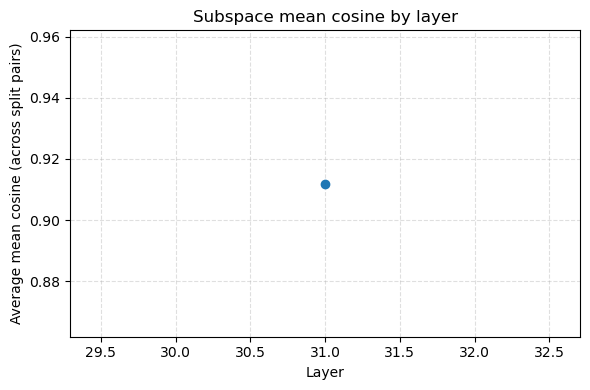

In [44]:
layer_sim_results: Dict[int, Tuple[Tuple[List[int], np.ndarray], List[Dict[str, Any]]]] = {}
layer_sim_summary: List[Dict[str, Any]] = []
for layer in LAYER_INDICES:
    sim_data, distance_rows = compute_layer_similarity(layer)
    if sim_data is None:
        continue
    keys, matrix = sim_data
    off_diag = matrix[np.triu_indices_from(matrix, k=1)]
    mean_cosine = float(np.mean(off_diag)) if off_diag.size else np.nan
    layer_sim_results[layer] = (sim_data, distance_rows)
    key_label = 'splits_used' if RANDOMIZE_SPLITS else 'depths_used'
    layer_sim_summary.append(
        {
            'layer': layer,
            'mean_cosine': mean_cosine,
            'pair_count': int(off_diag.size),
            key_label: len(keys),
        }
    )
if layer_sim_summary:
    summary_df = pd.DataFrame(layer_sim_summary).sort_values('layer').reset_index(drop=True)
    display(summary_df)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(summary_df['layer'], summary_df['mean_cosine'], marker='o')
    ax.set_xlabel('Layer')
    pair_label = 'split pairs' if RANDOMIZE_SPLITS else 'depth pairs'
    ax.set_ylabel(f'Average mean cosine (across {pair_label})')
    ax.set_title('Subspace mean cosine by layer')
    ax.grid(True, linestyle='--', alpha=0.4)
    fig.tight_layout()
    display(fig)
    plt.close(fig)
else:
    need_label = 'splits' if RANDOMIZE_SPLITS else 'depths'
    print(f'No layer-level similarity stats available (need >=2 {need_label} with probes).')

In [45]:
score_metric = SIMILARITY_SCORE[2] if len(SIMILARITY_SCORE) == 3 else 'pearson'
test_scores = distance_df[distance_df['split'] == SIMILARITY_SCORE[1]]
train_scores = distance_df[distance_df['split'] == 'train']
if SIMILARITY_LAYER_OVERRIDE is not None:
    SIM_LAYER = int(SIMILARITY_LAYER_OVERRIDE)
    reason = 'override'
    avg_score = np.nan
elif test_scores.empty:
    if train_scores.empty:
        SIM_LAYER = LAYER_INDICES[0]
        reason = 'fallback_first_layer'
        avg_score = np.nan
    else:
        avg_scores = train_scores.groupby('layer')[score_metric].mean()
        SIM_LAYER = int(avg_scores.idxmax())
        avg_score = float(avg_scores.loc[SIM_LAYER])
        reason = f'best train {score_metric}'
else:
    avg_scores = test_scores.groupby('layer')[score_metric].mean()
    SIM_LAYER = int(avg_scores.idxmax())
    avg_score = float(avg_scores.loc[SIM_LAYER])
    reason = f'best test {score_metric}'
print(f'Layer used for mean cosine plots: {SIM_LAYER} ({reason}; mean {score_metric}: {avg_score:.3f})')

Layer used for mean cosine plots: 31 (override; mean pearson: nan)


In [46]:
# Minimum principal angle across all probed layers and subspace pairs
min_record = None  # track (angle_rad, angle_deg, layer, key_a, key_b)
for layer in LAYER_INDICES:
    keys_for_layer = [k for k in sorted(depth_runs.keys()) if layer in depth_runs[k]['results']]
    if len(keys_for_layer) < 2:
        continue
    for i, key_a in enumerate(keys_for_layer):
        basis_a = _resolve_projection(depth_runs[key_a]['results'][layer])
        for key_b in keys_for_layer[i + 1 :]:
            basis_b = _resolve_projection(depth_runs[key_b]['results'][layer])
            cosines = principal_angle_cosines(basis_a, basis_b)
            angles_rad = np.arccos(np.clip(cosines, -1.0, 1.0))
            angle_rad = float(np.min(angles_rad))
            angle_deg = float(np.degrees(angle_rad))
            if (min_record is None) or (angle_rad < min_record[0]):
                min_record = (angle_rad, angle_deg, layer, key_a, key_b)

if min_record:
    angle_rad, angle_deg, layer, key_a, key_b = min_record
    print(
        f"Global min principal angle between probed subspaces: "
        f"{angle_rad:.4f} rad ({angle_deg:.2f} deg) at layer {layer} ({key_a} vs {key_b})"
    )
else:
    print('Need at least two probed subspaces in any layer to compute principal angles.')

Global min principal angle between probed subspaces: 0.1750 rad (10.03 deg) at layer 31 (0 vs 3)


,0,1,2,3,4
0,1.000000,0.927071,0.904706,0.931125,0.937902
1,0.927071,1.000000,0.912340,0.896994,0.939585
2,0.904706,0.912340,1.000000,0.858637,0.917704
3,0.931125,0.896994,0.858637,1.000000,0.893504
4,0.937902,0.939585,0.917704,0.893504,1.000000


,split_idx_a,split_idx_b,mean_cosine
6,1,4,0.939585
3,0,4,0.937902
2,0,3,0.931125
0,0,1,0.927071
8,2,4,0.917704
4,1,2,0.912340
1,0,2,0.904706
5,1,3,0.896994
9,3,4,0.893504
7,2,3,0.858637


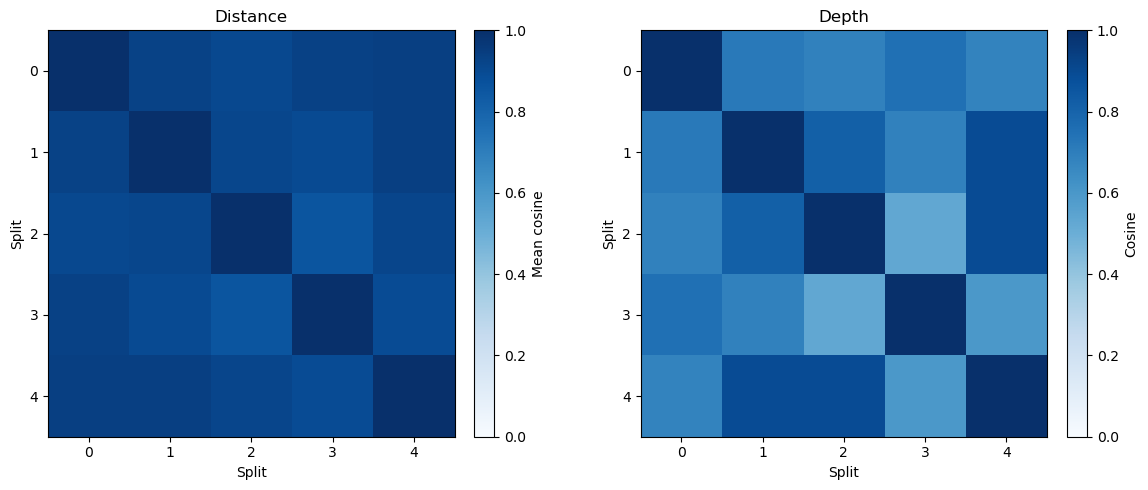

In [47]:
sim_data, distance_rows = layer_sim_results.get(SIM_LAYER, (None, []))
if sim_data is None:
    sim_data, distance_rows = compute_layer_similarity(SIM_LAYER)

# Compute depth probe similarities
depth_sim_data, depth_rows = compute_depth_probe_similarity(SIM_LAYER)

if sim_data is None:
    print('No trained probes available for similarity analysis.')
else:
    keys, dist_matrix = sim_data
    dist_df = pd.DataFrame(dist_matrix, index=keys, columns=keys)
    display(dist_df)
    if distance_rows:
        pairwise_distances_df = pd.DataFrame(distance_rows).sort_values('mean_cosine', ascending=False)
        display(pairwise_distances_df)
    else:
        print('No pairwise mean cosines to display.')

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axis_label = 'Split' if RANDOMIZE_SPLITS else 'Depth'
    
    # Left subplot: Distance probe similarity
    ax_dist = axes[0]
    # Force colorbar from 0 to 1
    im_dist = ax_dist.imshow(dist_matrix, vmin=0.0, vmax=1.0, cmap='Blues')
    ax_dist.set_xticks(range(len(keys)))
    ax_dist.set_xticklabels(keys)
    ax_dist.set_yticks(range(len(keys)))
    ax_dist.set_yticklabels(keys)
    ax_dist.set_xlabel(axis_label)
    ax_dist.set_ylabel(axis_label)
    ax_dist.set_title('Distance')
    cbar_dist = fig.colorbar(im_dist, ax=ax_dist, fraction=0.046, pad=0.04)
    cbar_dist.set_label('Mean cosine')
    
    # Right subplot: Depth probe similarity
    ax_depth = axes[1]
    if depth_sim_data is not None:
        depth_keys, depth_matrix = depth_sim_data
        # Force colorbar from 0 to 1
        im_depth = ax_depth.imshow(depth_matrix, vmin=0.0, vmax=1.0, cmap='Blues')
        ax_depth.set_xticks(range(len(depth_keys)))
        ax_depth.set_xticklabels(depth_keys)
        ax_depth.set_yticks(range(len(depth_keys)))
        ax_depth.set_yticklabels(depth_keys)
        ax_depth.set_xlabel(axis_label)
        ax_depth.set_ylabel(axis_label)
        ax_depth.set_title('Depth')
        cbar_depth = fig.colorbar(im_depth, ax=ax_depth, fraction=0.046, pad=0.04)
        cbar_depth.set_label('Cosine')
    else:
        ax_depth.text(0.5, 0.5, 'No depth probe\nsimilarities available', 
                      ha='center', va='center', transform=ax_depth.transAxes)
        ax_depth.set_title('Depth probe')
        ax_depth.set_xticks([])
        ax_depth.set_yticks([])
    
    fig.tight_layout()
    display(fig)
    plt.savefig(PROJECT_ROOT / "cutter/figures/paper/probe-similarities.png", dpi=300)
    plt.close(fig)

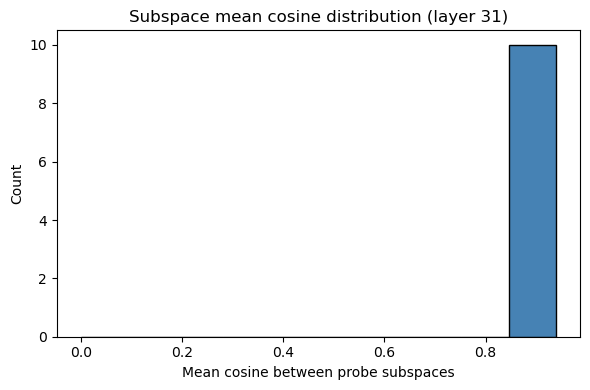

In [48]:
if depth_runs and len(depth_runs) > 1 and sim_data is not None:
    off_diag = dist_matrix[np.triu_indices_from(dist_matrix, k=1)] if 'dist_matrix' in locals() else np.array([])
    mean_cosines = off_diag.tolist() if off_diag.size else []
    if mean_cosines:
        fig_hist, ax_hist = plt.subplots(figsize=(6, 4))
        max_cosine = max(mean_cosines)
        bin_range = (0.0, max_cosine if max_cosine > 0 else 1.0)
        ax_hist.hist(mean_cosines, bins=10, range=bin_range, color='steelblue', edgecolor='black')
        ax_hist.set_xlabel('Mean cosine between probe subspaces')
        ax_hist.set_ylabel('Count')
        ax_hist.set_title(f'Subspace mean cosine distribution (layer {SIM_LAYER})')
        fig_hist.tight_layout()
        display(fig_hist)
        plt.close(fig_hist)
else:
    need_label = 'splits' if RANDOMIZE_SPLITS else 'depths'
    print(f'Histogram skipped: need probes for at least two {need_label}.')

In [49]:
rows = []
for key, payload in depth_runs.items():
    for layer, res in payload['results'].items():
        B = _resolve_projection(res)
        s = np.linalg.svd(B, compute_uv=False)
        thresh = s.max() * 1e-4
        rows.append({
            'split': key,
            'layer': layer,
            'proj_dim': B.shape[1],
            'eff_rank': int((s > thresh).sum()),
            's_min': float(s.min()),
            's_max': float(s.max()),
            'cond': float(s.max() / max(s.min(), 1e-12)),
        })
rank_df = pd.DataFrame(rows)
display(rank_df.sort_values(['split','layer']))

,split,layer,proj_dim,eff_rank,s_min,s_max,cond
0,0,31,5,5,0.001112,0.120993,108.768295
1,1,31,5,5,0.000116,0.097832,841.618896
2,2,31,5,5,0.000089,0.115688,1302.868530
3,3,31,5,5,0.000162,0.146013,902.453430
4,4,31,5,5,0.001746,0.104755,59.998554



## Cross-projection-dimension probe similarity

Compare pre-trained distance probes with projection dimensions 2, 4, 8, and 16 (when available). Loads the saved projection matrices and measures their mean cosines across layers.


Using dataset tag for projection-dim similarity: depth1-2_n1000_steps1-2


,layer,mean_cosine,pair_count
0,0,0.871860,6
1,1,0.997472,6
2,2,0.999444,6
3,3,0.982974,6
4,4,0.999210,6
5,5,0.998539,6
6,6,0.994938,6
7,7,0.996598,6
8,8,0.993243,6
9,9,0.995916,6


,layer,proj_dim_a,proj_dim_b,mean_cosine
5,0,4,5,0.917544
4,0,3,5,0.905692
1,0,2,4,0.877583
2,0,2,5,0.868226
3,0,3,4,0.842652
...,...,...,...,...
292,48,3,5,0.985975
290,48,2,5,0.928343
288,48,2,3,0.923520
291,48,3,4,0.879875


,2,3,4,5
2,1.000000,0.998213,0.999933,0.999935
3,0.998213,1.000000,0.999204,0.999820
4,0.999933,0.999204,1.000000,0.999997
5,0.999935,0.999820,0.999997,1.000000


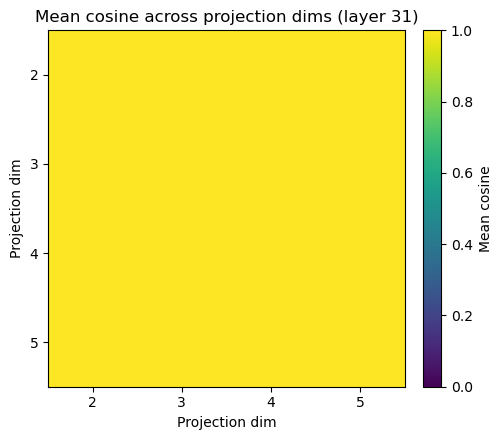

In [50]:
PROJ_DIMS_TO_COMPARE = (2, 3, 4, 5)
MODEL_ID = f"deepseek-ai/{MODEL_TAG}"

# Find a dataset tag that contains the desired probe files for this model
probe_root = PROJECT_ROOT / 'cutter' / 'data'
available_dims_by_tag: Dict[str, set[int]] = {}
for probe_file in probe_root.glob(f'*/models/{MODEL_TAG}/probes/probe_proj*.npz'):
    try:
        stem = probe_file.stem
        if '_pca' in stem:
            base, pca_part = stem.split('_pca', 1)
            try:
                pca_val = int(pca_part)
            except ValueError:
                pca_val = -1
            if pca_val != PCA_COMPONENTS:
                continue
            base = base.replace('probe_normtree_', 'probe_').replace('probe_', '')
            dim = int(base.replace('proj', ''))
        else:
            dim = int(stem.replace('probe_normtree_proj', '').replace('probe_proj', ''))
    except ValueError:
        continue
    dataset_tag_for_file = probe_file.parents[3].name
    available_dims_by_tag.setdefault(dataset_tag_for_file, set()).add(dim)

default_has_all = all(probe_path(DATASET_TAG, MODEL_ID, d, False, PCA_COMPONENTS).exists() for d in PROJ_DIMS_TO_COMPARE)
if default_has_all:
    probe_dataset_tag = DATASET_TAG
else:
    full_coverage = [tag for tag, dims in available_dims_by_tag.items() if all(d in dims for d in PROJ_DIMS_TO_COMPARE)]
    if full_coverage:
        probe_dataset_tag = sorted(full_coverage)[0]
    elif available_dims_by_tag:
        probe_dataset_tag = max(available_dims_by_tag.items(), key=lambda item: len(set(PROJ_DIMS_TO_COMPARE) & item[1]))[0]
    else:
        probe_dataset_tag = DATASET_TAG
print(f'Using dataset tag for projection-dim similarity: {probe_dataset_tag}')

# Load pre-trained probes for the requested projection dimensions
probe_runs: Dict[int, Dict[str, Any]] = {}
missing_dims: List[int] = []
for proj_dim in PROJ_DIMS_TO_COMPARE:
    probe_file = probe_path(probe_dataset_tag, MODEL_ID, proj_dim, False, PCA_COMPONENTS)
    if not probe_file.exists():
        missing_dims.append(proj_dim)
        continue
    with np.load(probe_file, allow_pickle=True) as payload:
        probe_runs[proj_dim] = {
            'path': probe_file,
            'meta': payload['meta'].item(),
            'results': payload['results'].item(),
        }

if missing_dims:
    print(f'Missing probe files for projection dims {missing_dims} (dataset tag: {probe_dataset_tag}).')
if len(probe_runs) < 2:
    print('Need at least two probe dimensions to compute cross-dimension similarity.')
else:
    shared_layers = sorted(set.intersection(*[set(run['results'].keys()) for run in probe_runs.values()])) if probe_runs else []
    if not shared_layers:
        print('No shared layers across loaded probe runs.')
    else:
        dim_keys = sorted(probe_runs)
        pairwise_rows: List[Dict[str, Any]] = []
        layer_distance_matrices: Dict[int, np.ndarray] = {}
        layer_summary_rows: List[Dict[str, Any]] = []
        for layer in shared_layers:
            matrix = np.eye(len(dim_keys), dtype=np.float32)
            for i, dim_a in enumerate(dim_keys):
                basis_a = _resolve_projection(probe_runs[dim_a]['results'][layer])
                for j, dim_b in enumerate(dim_keys):
                    if j <= i:
                        if j < i:
                            matrix[i, j] = matrix[j, i]
                        continue
                    basis_b = _resolve_projection(probe_runs[dim_b]['results'][layer])
                    cosine = mean_principal_angle_cosine(basis_a, basis_b)
                    matrix[i, j] = matrix[j, i] = cosine
                    pairwise_rows.append(
                        {
                            'layer': layer,
                            'proj_dim_a': dim_a,
                            'proj_dim_b': dim_b,
                            'mean_cosine': cosine,
                        }
                    )
            off_diag = matrix[np.triu_indices_from(matrix, k=1)]
            layer_distance_matrices[layer] = matrix
            layer_summary_rows.append(
                {
                    'layer': layer,
                    'mean_cosine': float(np.mean(off_diag)) if off_diag.size else np.nan,
                    'pair_count': int(off_diag.size),
                }
            )

        cross_dim_summary_df = pd.DataFrame(layer_summary_rows).sort_values('layer').reset_index(drop=True)
        display(cross_dim_summary_df)

        pairwise_df = pd.DataFrame(pairwise_rows)
        if not pairwise_df.empty:
            display(pairwise_df.sort_values(['layer', 'mean_cosine'], ascending=[True, False]))
        else:
            print('No pairwise mean cosines computed across projection dims.')

        viz_layer = SIM_LAYER if 'SIM_LAYER' in locals() and SIM_LAYER in layer_distance_matrices else shared_layers[0]
        viz_matrix = layer_distance_matrices[viz_layer]
        dim_labels = [str(d) for d in dim_keys]
        display(pd.DataFrame(viz_matrix, index=dim_labels, columns=dim_labels))

        fig, ax = plt.subplots(figsize=(5.5, 4.5))
        vmax = float(np.max(viz_matrix)) if viz_matrix.size else 1.0
        im = ax.imshow(viz_matrix, vmin=0.0, vmax=vmax, cmap='viridis')
        ax.set_xticks(range(len(dim_labels)))
        ax.set_xticklabels(dim_labels)
        ax.set_yticks(range(len(dim_labels)))
        ax.set_yticklabels(dim_labels)
        ax.set_xlabel('Projection dim')
        ax.set_ylabel('Projection dim')
        ax.set_title(f'Mean cosine across projection dims (layer {viz_layer})')
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Mean cosine')
        fig.tight_layout()
        display(fig)
        plt.close(fig)